In [ ]:
!pip install yfinance statsmodels tensorflow pmdarima

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from pmdarima.arima import auto_arima
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from math import sqrt
import time_seri_forecast as tsf
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Time Series Forecasting**

***Load dataset from CSV***

In [2]:
data = pd.read_csv('/content/financial_data.csv', index_col=0, parse_dates=True)
ticker = 'TSLA'
df = data[[ticker]].dropna()
df.head()

,TSLA
Date,
2015-01-02,14.620667
2015-01-05,14.006000
2015-01-06,14.085333
2015-01-07,14.063333
2015-01-08,14.041333


***Train_test Split***

In [3]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

***ARIMA Model***

In [4]:
try:
    # AutoARIMA automatically selects best p, d, q
    auto_arima_model = auto_arima(train, seasonal=False, stepwise=True, trace=True)
    arima_forecast = auto_arima_model.predict(n_periods=len(test))
except Exception as e:
    print(f"Error fitting AutoARIMA: {e}")
    arima_forecast = np.full(len(test), np.nan)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12684.802, Time=1.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12680.726, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12679.653, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12679.753, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12678.997, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12680.805, Time=3.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 7.070 seconds


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


***SARIMA Model***

In [5]:
try:
    sarima_model = SARIMAX(
        train, order=(1, 1, 0), seasonal_order=(1, 0, 0, 52)
    )  # Adjusted seasonal order
    sarima_fit = sarima_model.fit()
    sarima_forecast = sarima_fit.forecast(steps=len(test))
except Exception as e:
    print(f"Error fitting SARIMA: {e}")
    sarima_forecast = np.full(len(test), np.nan)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


***LSTM Model***

In [13]:
# seq_length=60 LSTM - MAE: 52.0999, RMSE: 71.8282, MAPE: 25.1661
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

seq_length = 60
X_train, y_train = tsf.create_sequences(train_scaled, seq_length)
X_test, y_test = tsf.create_sequences(test_scaled, seq_length)

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

try:
  model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
  lstm_forecast = model.predict(X_test)
  lstm_forecast = scaler.inverse_transform(lstm_forecast)
except Exception as e:
  print(f"Error fitting LSTM: {e}")
  lstm_forecast = np.full(len(test), np.nan)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [15]:
# seq_length=30 LSTM - MAE: 36.4107, RMSE: 50.0971, MAPE: 16.6302
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

seq_length = 30
X_train, y_train = tsf.create_sequences(train_scaled, seq_length)
X_test, y_test = tsf.create_sequences(test_scaled, seq_length)

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

try:
  model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=0)
  lstm_forecast2 = model.predict(X_test)
  lstm_forecast2 = scaler.inverse_transform(lstm_forecast2)
except Exception as e:
  print(f"Error fitting LSTM: {e}")
  lstm_forecast2 = np.full(len(test), np.nan)

tsf.calculate_metrics(test, lstm_forecast2, 'LSTM')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
LSTM - MAE: 36.4107, RMSE: 50.0971, MAPE: 16.6302


***Evaluation***

In [16]:
tsf.calculate_metrics(test, arima_forecast, 'ARIMA')
tsf.calculate_metrics(test, sarima_forecast, 'SARIMA')
tsf.calculate_metrics(test, lstm_forecast, 'LSTM')


ARIMA - MAE: 89.9096, RMSE: 111.0784, MAPE: nan
SARIMA - MAE: 87.6695, RMSE: 109.2481, MAPE: nan
LSTM - MAE: 52.0999, RMSE: 71.8282, MAPE: 25.1661


***Visualization***

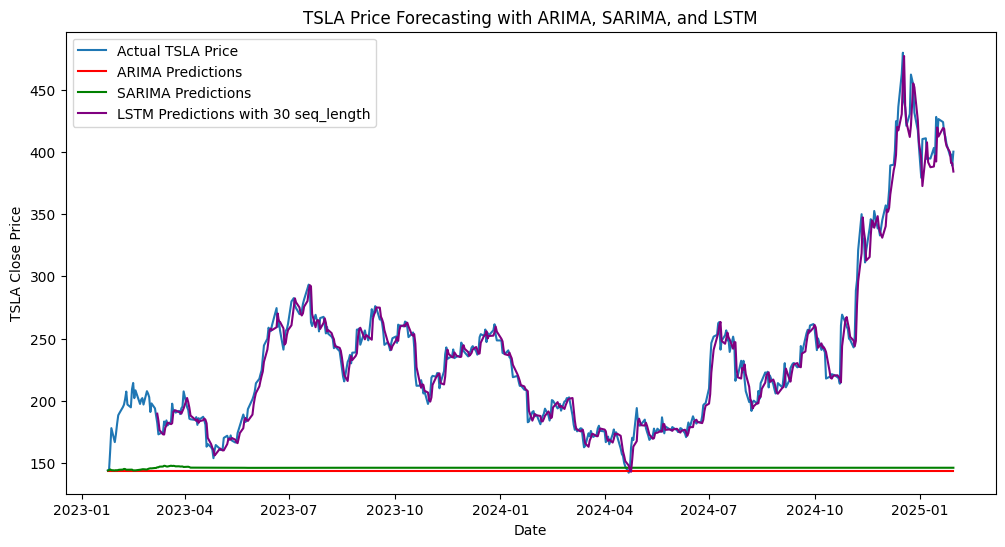

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual TSLA Price")
plt.plot(test.index, arima_forecast, label="ARIMA Predictions", color="red")
plt.plot(test.index, sarima_forecast, label="SARIMA Predictions", color="green")
plt.plot(
    test.index[seq_length:],
    lstm_forecast2,
    label="LSTM Predictions with 30 seq_length",
    color="purple",
)
plt.xlabel("Date")
plt.ylabel("TSLA Close Price")
plt.title("TSLA Price Forecasting with ARIMA, SARIMA, and LSTM")
plt.legend()
plt.show()

In [26]:
# Ensure the lengths of the forecast arrays match the test index length
len_test = len(test)

# Resize forecasts to match the test set length if necessary
if len(arima_forecast) != len_test:
    arima_forecast = np.resize(arima_forecast, len_test)
if len(sarima_forecast) != len_test:
    sarima_forecast = np.resize(sarima_forecast, len_test)

# Flatten the LSTM forecast if it's a 2D array (lstm_forecast2)
if lstm_forecast2.ndim > 1:
    lstm_forecast2 = lstm_forecast2.flatten()

# Ensure LSTM forecast matches the length of the test set
if len(lstm_forecast2) != len_test:
    lstm_forecast2 = np.resize(lstm_forecast2, len_test)

# Create DataFrame and save to CSV
try:
    forecasts_df = pd.DataFrame({
        'ARIMA': arima_forecast,
        'SARIMA': sarima_forecast,
        'LSTM': lstm_forecast2  # Using lstm_forecast2 here
    })
    forecasts_df.to_csv('/content/forecasts.csv', index=False)
    print("Forecasts saved to /content/forecasts.csv")
except ValueError as e:
    print(f"Error creating DataFrame: {e}")

# Save the trained LSTM model
try:
    model.save('/content/lstm_model.keras')  # Save the trained LSTM model in .keras format
    print("LSTM model saved successfully in Keras format!")
except Exception as e:
    print(f"Error saving LSTM model: {e}")


Forecasts saved to /content/forecasts.csv
LSTM model saved successfully in Keras format!


In [ ]:
# Save the trained LSTM model as a .pkl file
with open('/content/lstm_model.pkl', 'wb') as file:
    pickle.dump(model, file)
print("Model saved as lstm_model.pkl")

Model saved as lstm_model.pkl
